In [34]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [39]:
data = pd.read_csv("data/Goblin_SingleQLAI_Goblin2(5).csv")
print("Num rows: ", len(data))
print("Cols: ", data.keys())
data.head()

Num rows:  25045
Cols:  Index(['pos_x_diff', 'pos_y_diff', 'enemy_dist', 'self_life', 'enemy_life',
       'enemy_attacking', 'enemy_dir_x', 'enemy_dir_y', 'q_val', 'reward',
       'next_val', 'priority', 'epsilon', 'experience_size', 'time', 'exp_id',
       'replay', 'terminal', 'idle_q', 'attack_q', 'walk_right_q',
       'walk_up_right_q', 'walk_up_q', 'walk_up_left_q', 'walk_left_q',
       'walk_down_left_q', 'walk_down_q', 'walk_down_right_q'],
      dtype='object')


,pos_x_diff,pos_y_diff,enemy_dist,self_life,enemy_life,enemy_attacking,enemy_dir_x,enemy_dir_y,q_val,reward,...,idle_q,attack_q,walk_right_q,walk_up_right_q,walk_up_q,walk_up_left_q,walk_left_q,walk_down_left_q,walk_down_q,walk_down_right_q
0,-0.063155,-0.055721,0.084222,1.0,1.0,-1,0,1,-0.385937,0.0,...,-0.384861,-0.384861,-0.384458,-0.384504,-0.384759,-0.385074,-0.385263,-0.385216,-0.384962,-0.384648
1,-0.064293,-0.051171,0.082171,1.0,1.0,-1,0,1,-0.384861,0.0,...,-0.078619,-0.078619,-0.078284,-0.078257,-0.078442,-0.078731,-0.078952,-0.078978,-0.078794,-0.078507
2,-0.059543,-0.049204,0.077242,1.0,1.0,-1,1,0,-0.078619,0.0,...,-0.078619,-0.078619,-0.078284,-0.078257,-0.078442,-0.078731,-0.078952,-0.078978,-0.078794,-0.078507
3,-0.059543,-0.049204,0.077242,1.0,1.0,-1,1,0,-0.078619,0.0,...,-0.261849,-0.261849,-0.261670,-0.261611,-0.261692,-0.261864,-0.262027,-0.262085,-0.262005,-0.261833
4,-0.064293,-0.060671,0.088400,1.0,1.0,-1,0,-1,-0.261849,0.0,...,-0.079391,-0.079391,-0.079073,-0.079054,-0.079233,-0.079505,-0.079709,-0.079726,-0.079548,-0.079278


In [40]:
discount = 0.999

q_vals = data.filter(regex="_q$")
data["q_avg"] = q_vals.mean(axis=1)
data["q_std"] = q_vals.std(axis=1)

data["label"] = data["reward"] + discount * data["next_val"] * (~ data["terminal"])

replay_data = data[data["replay"] == True]
real_time_data = data[data["replay"] == False]

replay_times = sorted(replay_data["time"].value_counts().keys().tolist())
max_time = max(data["time"]) + 0.1

print(len(data[data["reward"] == 0.0]))
print("Max time: ", max_time)
print()
print(data["replay"].value_counts())
print()
print(data[["q_avg", "q_std"]].head())
print()
print(data.describe())

24761
Max time:  504.6

True     20000
False     5045
Name: replay, dtype: int64

      q_avg     q_std
0 -0.384861  0.000277
1 -0.078618  0.000252
2 -0.078618  0.000252
3 -0.261848  0.000158
4 -0.079391  0.000237

         pos_x_diff    pos_y_diff    enemy_dist     self_life    enemy_life  \
count  25045.000000  25045.000000  25045.000000  25045.000000  25045.000000   
mean      -0.029018      0.016703      0.117029      0.912780      0.970653   
std        0.086751      0.083964      0.044726      0.180328      0.107089   
min       -0.163354     -0.160915      0.010149      0.097798      0.333333   
25%       -0.108353     -0.049264      0.084398      1.000000      1.000000   
50%       -0.037486      0.012606      0.121525      1.000000      1.000000   
75%        0.030872      0.089821      0.147813      1.000000      1.000000   
max        0.157693      0.167823      0.225659      1.000000      1.000000   

       enemy_attacking   enemy_dir_x   enemy_dir_y         q_val  \
count

In [41]:
def plot_replay_lines(df, y_var):
    max_val = max(df[y_var])
    min_val = min(df[y_var])
    lines = []
    for time in replay_times:
        lines.append([time, time])
        lines.append([min_val, max_val])
    plt.plot(*lines, linestyle=":", color="green")
    
def separate_outliers(df, var, c=1.5):
    quantiles = df[var].quantile([0.25, 0.75])
    iq_height = quantiles[0.75] - quantiles[0.25]
    outliers_range = [quantiles[0.25] - c * iq_height, quantiles[0.75] + c * iq_height]
    outliers = df[(df[var] < outliers_range[0]) | (df[var] > outliers_range[1])]
    not_outliers = df[(df[var] >= outliers_range[0]) & (df[var] <= outliers_range[1])]
    return not_outliers, outliers

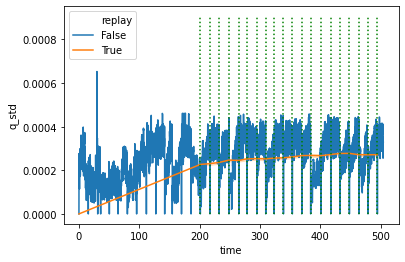

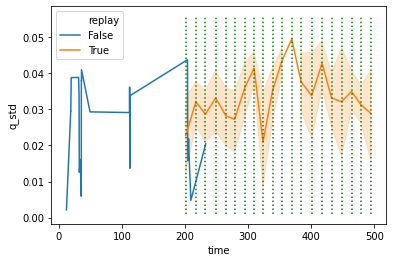

In [42]:
time_q_std = data[["time", "q_std", "replay"]]
c = 2.5

# Add extra row with zeros, so the graph looks better
extra_rows = pd.DataFrame([[0.0, 0.0, True], [0.0, 0.0, False]],
                          columns=["time", "q_std", "replay"])
time_q_std = pd.concat([extra_rows, time_q_std])
not_outliers, outliers = separate_outliers(time_q_std, "q_std", c=4.0)

sns.lineplot(x="time", y="q_std", hue="replay", data=not_outliers)
plot_replay_lines(not_outliers, "q_std")
plt.show()

sns.lineplot(x="time", y="q_std", hue="replay", data=outliers)
plot_replay_lines(outliers, "q_std")
plt.show()

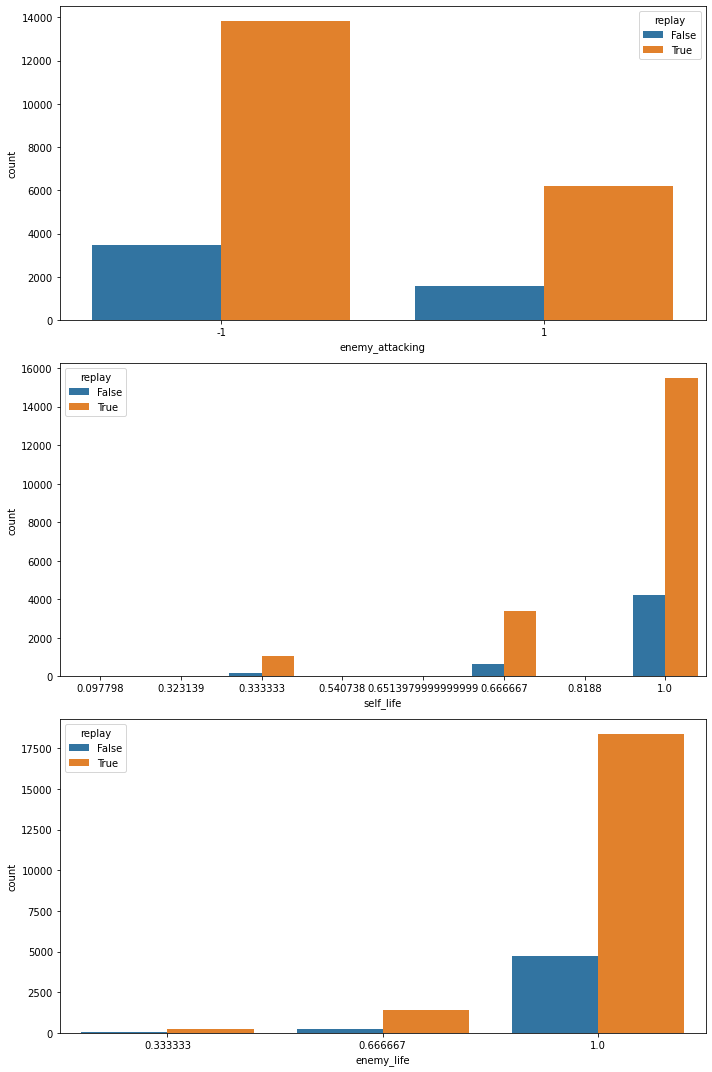

In [43]:
rows = ['enemy_attacking', 'self_life', 'enemy_life']

fig, ax = plt.subplots(len(rows), 1, figsize=(10, 15))
for i in range(len(rows)):
    sns.countplot(x=rows[i], hue="replay", data=data, ax=ax[i])
plt.tight_layout()
plt.show()

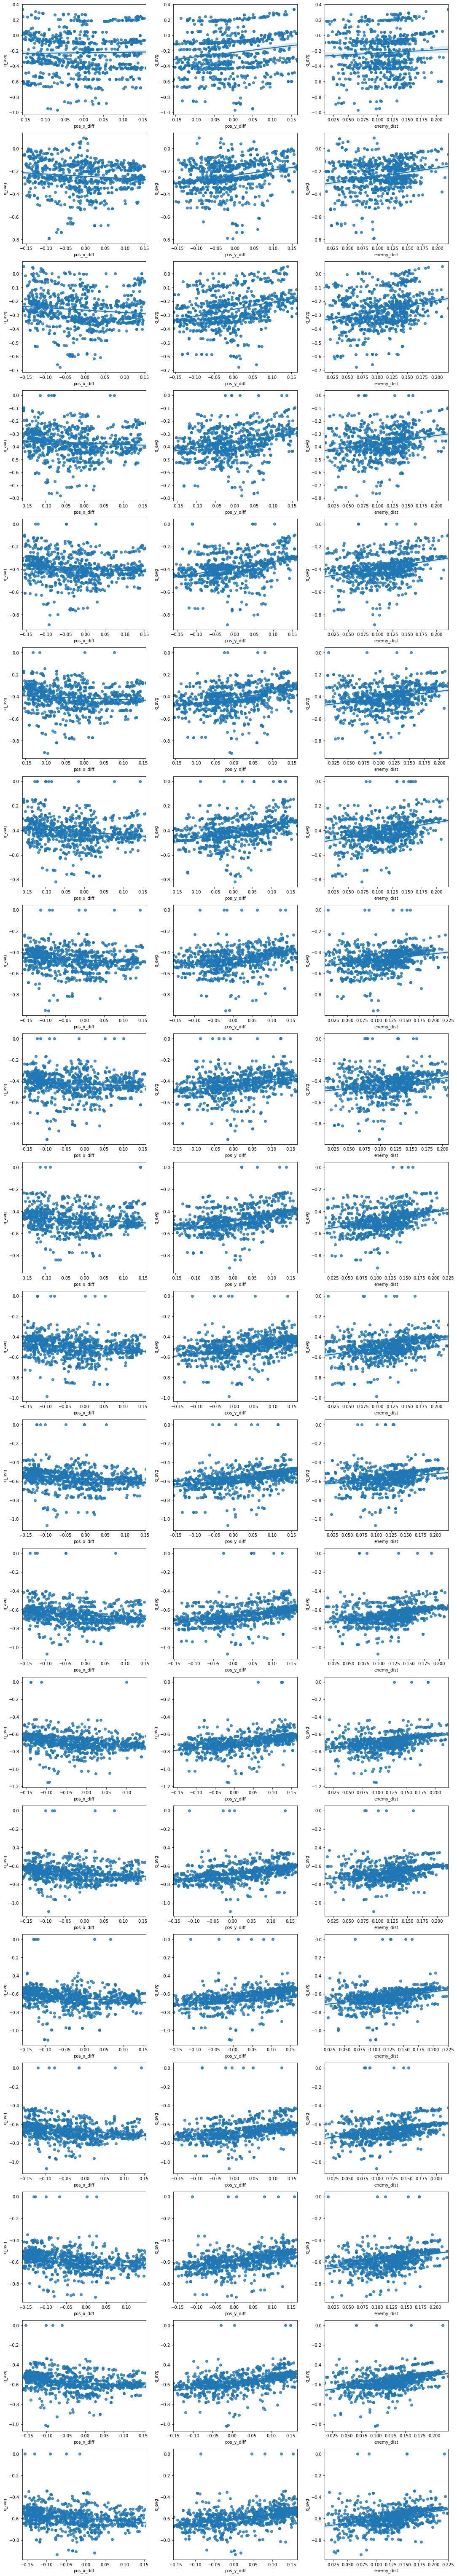

In [44]:
cols = ['pos_x_diff', 'pos_y_diff', 'enemy_dist']

fig, ax = plt.subplots(len(replay_times), len(cols), figsize=(15, 4.25 * len(replay_times)))
for i in range(len(replay_times)):
    time_data = replay_data[replay_data["time"] == replay_times[i]]
    for j in range(len(cols)):
        sns.regplot(x=cols[j], y="q_avg", data=time_data, ax=ax[i][j])
plt.tight_layout()
plt.show()

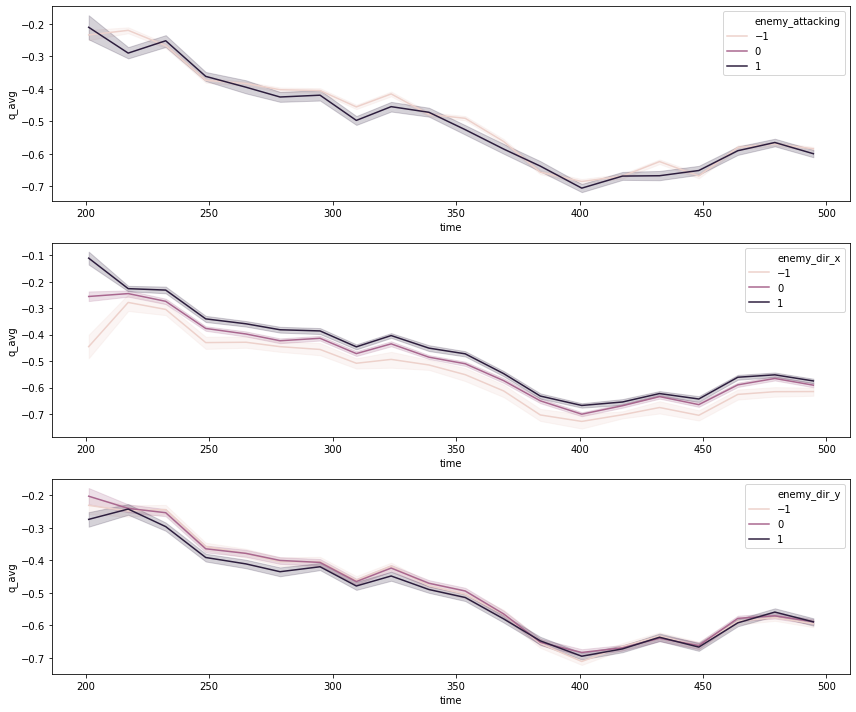

In [45]:
rows = ['enemy_attacking', 'enemy_dir_x', 'enemy_dir_y']

fig, ax = plt.subplots(len(rows), 1, figsize=(12, 10))
for i in range(len(rows)):
    sns.lineplot(x="time", y="q_avg", hue=rows[i], data=replay_data, ax=ax[i])
plt.tight_layout()
plt.show()

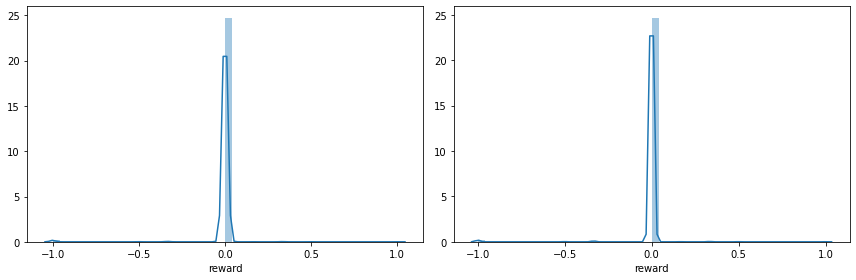

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(real_time_data["reward"], ax=ax[0])
sns.distplot(replay_data["reward"], ax=ax[1])
plt.tight_layout()
plt.show()

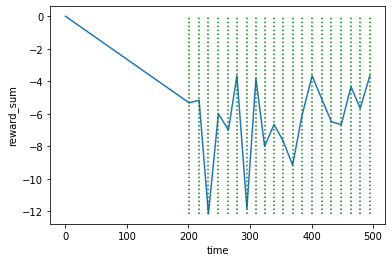

In [47]:
# Group rewards by time and accumulate them
reward_time = replay_data.groupby(by="time")["reward"].sum().to_frame("reward_sum").reset_index()
# Add extra row with zeros, so the graph looks better
reward_time = pd.concat([pd.DataFrame([[0.0, 0.0]], columns=["time", "reward_sum"]), reward_time])
# Plot the graph
sns.lineplot(x="time", y="reward_sum", data=reward_time)

plot_replay_lines(reward_time, "reward_sum")
plt.show()

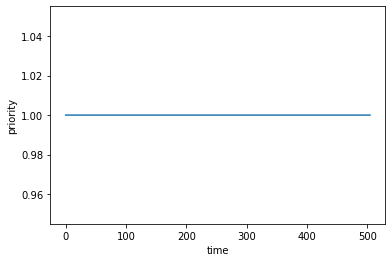

In [48]:
sns.lineplot(x="time", y="priority", data=real_time_data)

plot_replay_lines(real_time_data, "priority")
plt.show()

In [49]:
terminal_priority = data[["terminal", "priority"]]
print(terminal_priority[terminal_priority["terminal"] == False].describe())
print(terminal_priority[terminal_priority["terminal"] == True].describe())

       terminal  priority
count   24887.0   24887.0
mean        0.0       1.0
std         0.0       0.0
min         0.0       1.0
25%         0.0       1.0
50%         0.0       1.0
75%         0.0       1.0
max         0.0       1.0
       terminal  priority
count     158.0     158.0
mean        1.0       1.0
std         0.0       0.0
min         1.0       1.0
25%         1.0       1.0
50%         1.0       1.0
75%         1.0       1.0
max         1.0       1.0


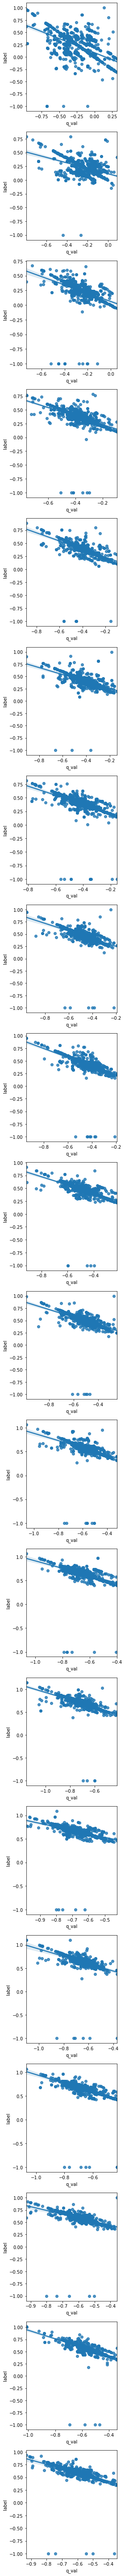

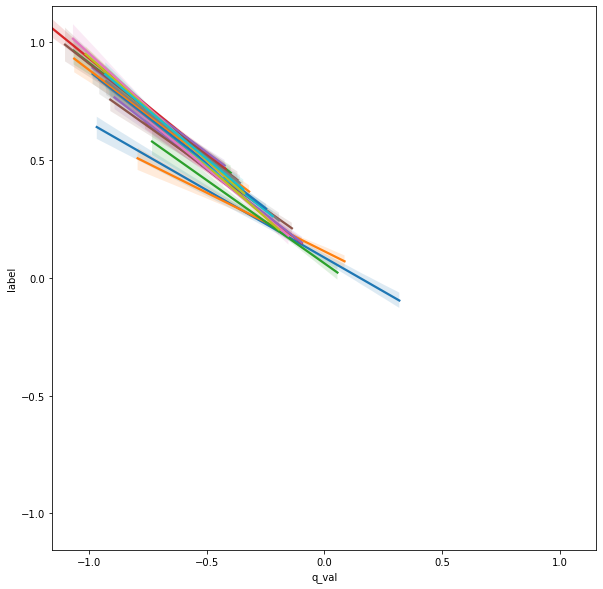

In [51]:
# relação entre os q_val e next_val
fig, ax = plt.subplots(len(replay_times), 1, figsize=(4, 4 * len(replay_times)))
for i in range(len(replay_times)):
    sns.regplot(x="q_val", y="label", data=replay_data[replay_data["time"] == replay_times[i]], ax=ax[i])
plt.tight_layout()
plt.show()

axis_max = max([max(replay_data["label"]), max(replay_data["q_val"])])
axis_min = min([min(replay_data["label"]), min(replay_data["q_val"])])

plt.figure(figsize=(10, 10))
for i in range(len(replay_times)):
    sns.regplot(x="q_val", y="label", data=replay_data[replay_data["time"] == replay_times[i]], scatter=False)
plt.xlim(axis_min, axis_max)
plt.ylim(axis_min, axis_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# Primeira linha é a azul escura